# Auckland House Prices Analysis

## Executive Summary:

It is of interest to build a predictive model for the Capital value of Auckland properties. The original dataset given consists of typical housing attributes and the SA1 area unit classification, along with the number of people from different ages groups within the SA1 area. To improve this dataset, two variables were added:

* The 2018 recorded population at the addresses in our dataset, based on the 2018 census and Koordinate. 
* The 2018 Deprivation index which is an indicator of the socio-economic status for a SA1 area.

After the data cleaning stage, the final dataset consisted of 1050 observations (an outlier was removed) and 14 explanatory variables. 

Different models and transformations were applied, and the resulting model used was a random forest model with a prediction score of 53.3%. 


## 1. Data collection - API calling and Webscraping

In [269]:
import sys
import json
import pandas as pd
import requests
import time
import re
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

In [91]:
"""
# defined a function to get the C18_CURPop
# Inputs:
# - lat = latitude
# - lon = logitude
# Outputs:
# - C18_CURPop
""""

def get_C18_CURPop(lat,lon):
    url = 'https://koordinates.com/services/query/v1/vector.json'
    params = {
        'key': '39747fad883a4b3786e25fc80942264d',
        'layer': '104612',
        'x':lon,
        'y':lat
    }
    response = requests.get(url,params=params)
    
    if response.status_code !=200:
        return pd.Series({'C18_CURPop':response.status_code})
    
    C18_CURPop = response.json()['vectorQuery']['layers']['104612']['features'][0]['properties']['C18_CURPop']
    return pd.Series({'C18_CURPop':C18_CURPop})

Test if function is working correctly:

In [65]:
get_C18_CURPop(-37.0129205,174.90406940000003)

C18_CURPop    174
dtype: int64

Read in the assignment csv

In [32]:
df = pd.read_csv('Dataset for Assignment.csv')

Append the column to the assignment dataset. Code is commented to prevent running again as it takes awhile. The combined file was saved and loaded when required instead of running this step.

In [33]:
#df['C18_CURPop'] = df.apply(lambda x: get_C18_CURPop(x['Latitude'],x['Longitude']),axis=1)
#df.to_csv('data_with_census.csv')

NameError: ("name 'get_C18_CURPop' is not defined", 'occurred at index 0')

Loading dataset with the C18_CURPop column

In [271]:
df= pd.read_csv('data_with_census.csv')

In [272]:
df.head()

,Unnamed: 0,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop
0,0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174
1,1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129
2,2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129
3,3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120
4,4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231


Download file to get the Deprivation Index

In [36]:
!curl https://www.otago.ac.nz/wellington/otago730418.txt -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1192k  100 1192k    0     0   153k      0  0:00:07  0:00:07 --:--:--  200k


Read in the dataset (delimiter is tabs).

In [293]:
sa_df = pd.read_csv('otago730418.txt',sep = "\t")

In [294]:
sa_df.head()

,SA12018_code,NZDep2018,NZDep2018_Score,URPopnSA1_2018,SA22018_code,SA22018_name
0,7000000,10.0,1245.0,141,100100,North Cape
1,7000001,10.0,1245.0,114,100100,North Cape
2,7000002,NaN,NaN,0,100300,Inlets Far North District
3,7000003,10.0,1207.0,225,100100,North Cape
4,7000004,9.0,1093.0,138,100100,North Cape


Drop columns that are not need. Only keep the column required for merging and the NZ Deprivation Index

In [295]:
sa_df = sa_df.drop(['NZDep2018_Score','URPopnSA1_2018','SA22018_code','SA22018_name'],axis=1) 

Create a new temporary dataframe to complete the merge

In [296]:
temp_df = df

In [297]:
joined_df = pd.merge(temp_df,sa_df, how = 'left',left_on = 'SA1',right_on = 'SA12018_code')

In [298]:
joined_df.head()

,Unnamed: 0,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,SA12018_code,NZDep2018
0,0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,7009770,6.0
1,1,5,3.0,"8 Corsica Way Karaka, Auckland",564,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,7009991,1.0
2,2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,7009991,1.0
3,3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,7007871,2.0
4,4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,7008902,9.0


Removed the unnecessary columns from the dataset

In [299]:
joined_df = joined_df.drop(['Unnamed: 0','SA12018_code'], axis = 1)

In [300]:
joined_df.to_csv('combined_data.csv')

# 2. Data Analysis and Model building

## 2.1. Data Cleaning

In [301]:
joined_df= pd.read_csv('combined_data.csv')

In [302]:
joined_df.dtypes

Unnamed: 0       int64
Bedrooms         int64
Bathrooms      float64
Address         object
Land area       object
CV               int64
Latitude       float64
Longitude      float64
SA1              int64
0-19 years       int64
20-29 years      int64
30-39 years      int64
40-49 years      int64
50-59 years      int64
60+ years        int64
Suburbs         object
C18_CURPop       int64
NZDep2018      float64
dtype: object

Drop extra columns

In [303]:
joined_df = joined_df.drop(['Unnamed: 0'], axis = 1)

Clean the land area column, as some values contained " m^2". We only want numeric values.

In [305]:
joined_df['Land area'] = joined_df['Land area'].str.extract('(\d+)').astype(float)

In [306]:
joined_df.dtypes

Bedrooms         int64
Bathrooms      float64
Address         object
Land area      float64
CV               int64
Latitude       float64
Longitude      float64
SA1              int64
0-19 years       int64
20-29 years      int64
30-39 years      int64
40-49 years      int64
50-59 years      int64
60+ years        int64
Suburbs         object
C18_CURPop       int64
NZDep2018      float64
dtype: object

In [307]:
joined_df.describe()

,Bedrooms,Bathrooms,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,C18_CURPop,NZDep2018
count,1051.000000,1049.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,3.777355,2.073403,856.989534,1.387521e+06,-36.893715,174.799325,7.006319e+06,47.549001,28.963844,27.042816,24.125595,22.615604,29.360609,179.914367,5.063749
std,1.169412,0.992985,1588.156219,1.182939e+06,0.130100,0.119538,2.591262e+03,24.692205,21.037441,17.975408,10.942770,10.210578,21.805031,71.059280,2.913471
min,1.000000,1.000000,40.000000,2.700000e+05,-37.265021,174.317078,7.001130e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000
25%,3.000000,1.000000,321.000000,7.800000e+05,-36.950565,174.720779,7.004416e+06,33.000000,15.000000,15.000000,18.000000,15.000000,18.000000,138.000000,2.000000
50%,4.000000,2.000000,571.000000,1.080000e+06,-36.893132,174.798575,7.006325e+06,45.000000,24.000000,24.000000,24.000000,21.000000,27.000000,174.000000,5.000000
75%,4.000000,3.000000,825.000000,1.600000e+06,-36.855789,174.880944,7.008384e+06,57.000000,36.000000,33.000000,30.000000,27.000000,36.000000,210.000000,8.000000
max,17.000000,8.000000,22240.000000,1.800000e+07,-36.177655,175.492424,7.011028e+06,201.000000,270.000000,177.000000,114.000000,90.000000,483.000000,789.000000,10.000000


Check if there is any null values in dataset

In [67]:
joined_df.isnull().values.any()

True

Check which columns contained nulls

In [50]:
joined_df.isnull().sum()

Bedrooms        0
Bathrooms       2
Address         0
Land area       0
CV              0
Latitude        0
Longitude       0
SA1             0
0-19 years      0
20-29 years     0
30-39 years     0
40-49 years     0
50-59 years     0
60+ years       0
Suburbs         1
C18_CURPop      0
SA12018_code    0
NZDep2018       0
dtype: int64

Take a look at the rows with nulls

In [309]:
null_rows = joined_df[joined_df.isnull().any(axis=1)]
null_rows

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
309,4,NaN,"14 Hea Road Hobsonville, Auckland",214.0,1250000,-36.798371,174.647430,7002267,60,66,60,24,24,18,Hobsonville,252,2.0
311,4,NaN,"16 Hea Road Hobsonville, Auckland",245.0,1100000,-36.798371,174.647430,7002267,60,66,60,24,24,18,Hobsonville,252,2.0
568,1,1.0,"14 Te Rangitawhiri Road Great Barrier Island, ...",2141.0,740000,-36.197282,175.416921,7001131,27,6,6,18,39,60,NaN,156,9.0


The SA1 is related to the suburb and we can look for rows with the same SA1, and use their suburb value for the missing value. 

In [310]:
joined_df.loc[joined_df['SA1'] == 7001131]

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
568,1,1.0,"14 Te Rangitawhiri Road Great Barrier Island, ...",2141.0,740000,-36.197282,175.416921,7001131,27,6,6,18,39,60,NaN,156,9.0
569,5,3.0,"349 Blind Bay Road Great Barrier Island, Auckland",3953.0,920000,-36.257895,175.436448,7001131,27,6,6,18,39,60,Great Barrier Island (Aotea Island),156,9.0


In [311]:
joined_df.at[568,'Suburbs'] = joined_df.iloc[569]['Suburbs']

In [312]:
joined_df.loc[joined_df['SA1'] == 7001131]

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
568,1,1.0,"14 Te Rangitawhiri Road Great Barrier Island, ...",2141.0,740000,-36.197282,175.416921,7001131,27,6,6,18,39,60,Great Barrier Island (Aotea Island),156,9.0
569,5,3.0,"349 Blind Bay Road Great Barrier Island, Auckland",3953.0,920000,-36.257895,175.436448,7001131,27,6,6,18,39,60,Great Barrier Island (Aotea Island),156,9.0


To impute the missing bathroom values, the average bathroom for houses with 4 bedrooms was used. 

In [313]:
impute_val = round(joined_df.loc[joined_df['Bedrooms'] == 4]['Bathrooms'].mean(),0)

In [314]:
rep_ind = [309,311]

for i in range(len(rep_ind)):
    joined_df.at[rep_ind[i],'Bathrooms'] = impute_val

Check if there are any more missing values

In [26]:
joined_df.isnull().values.any()

False

## 2.2. Exploratory Analysis

Take a quick look at the mean, min, max and quartiles. Initially, there were 1051 observations in the dataset. 

In [316]:
joined_df.describe()

,Bedrooms,Bathrooms,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,C18_CURPop,NZDep2018
count,1051.000000,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1.051000e+03,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,3.777355,2.073264,856.989534,1.387521e+06,-36.893715,174.799325,7.006319e+06,47.549001,28.963844,27.042816,24.125595,22.615604,29.360609,179.914367,5.063749
std,1.169412,0.992044,1588.156219,1.182939e+06,0.130100,0.119538,2.591262e+03,24.692205,21.037441,17.975408,10.942770,10.210578,21.805031,71.059280,2.913471
min,1.000000,1.000000,40.000000,2.700000e+05,-37.265021,174.317078,7.001130e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000
25%,3.000000,1.000000,321.000000,7.800000e+05,-36.950565,174.720779,7.004416e+06,33.000000,15.000000,15.000000,18.000000,15.000000,18.000000,138.000000,2.000000
50%,4.000000,2.000000,571.000000,1.080000e+06,-36.893132,174.798575,7.006325e+06,45.000000,24.000000,24.000000,24.000000,21.000000,27.000000,174.000000,5.000000
75%,4.000000,3.000000,825.000000,1.600000e+06,-36.855789,174.880944,7.008384e+06,57.000000,36.000000,33.000000,30.000000,27.000000,36.000000,210.000000,8.000000
max,17.000000,8.000000,22240.000000,1.800000e+07,-36.177655,175.492424,7.011028e+06,201.000000,270.000000,177.000000,114.000000,90.000000,483.000000,789.000000,10.000000


Take a look at the distribution of the numeric variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdad8afc080>,
      dtype=object)

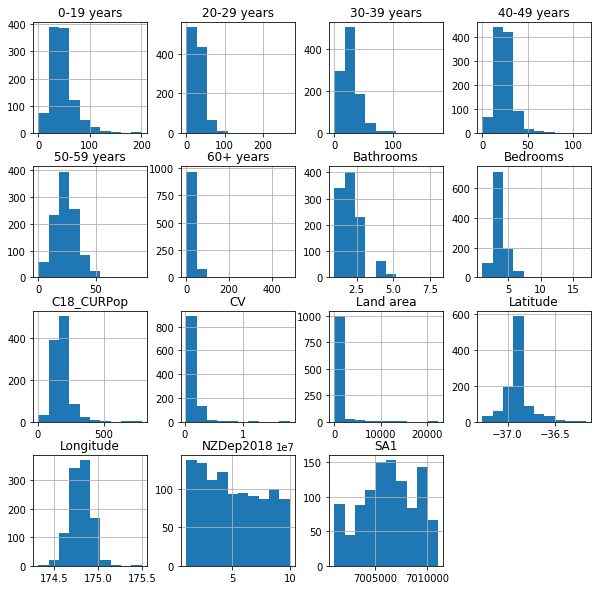

In [317]:
joined_df.hist(figsize=(10,10))

I noticed that many of the variables seem to be right skewed. This suggest that a log transform may be required in the model. 

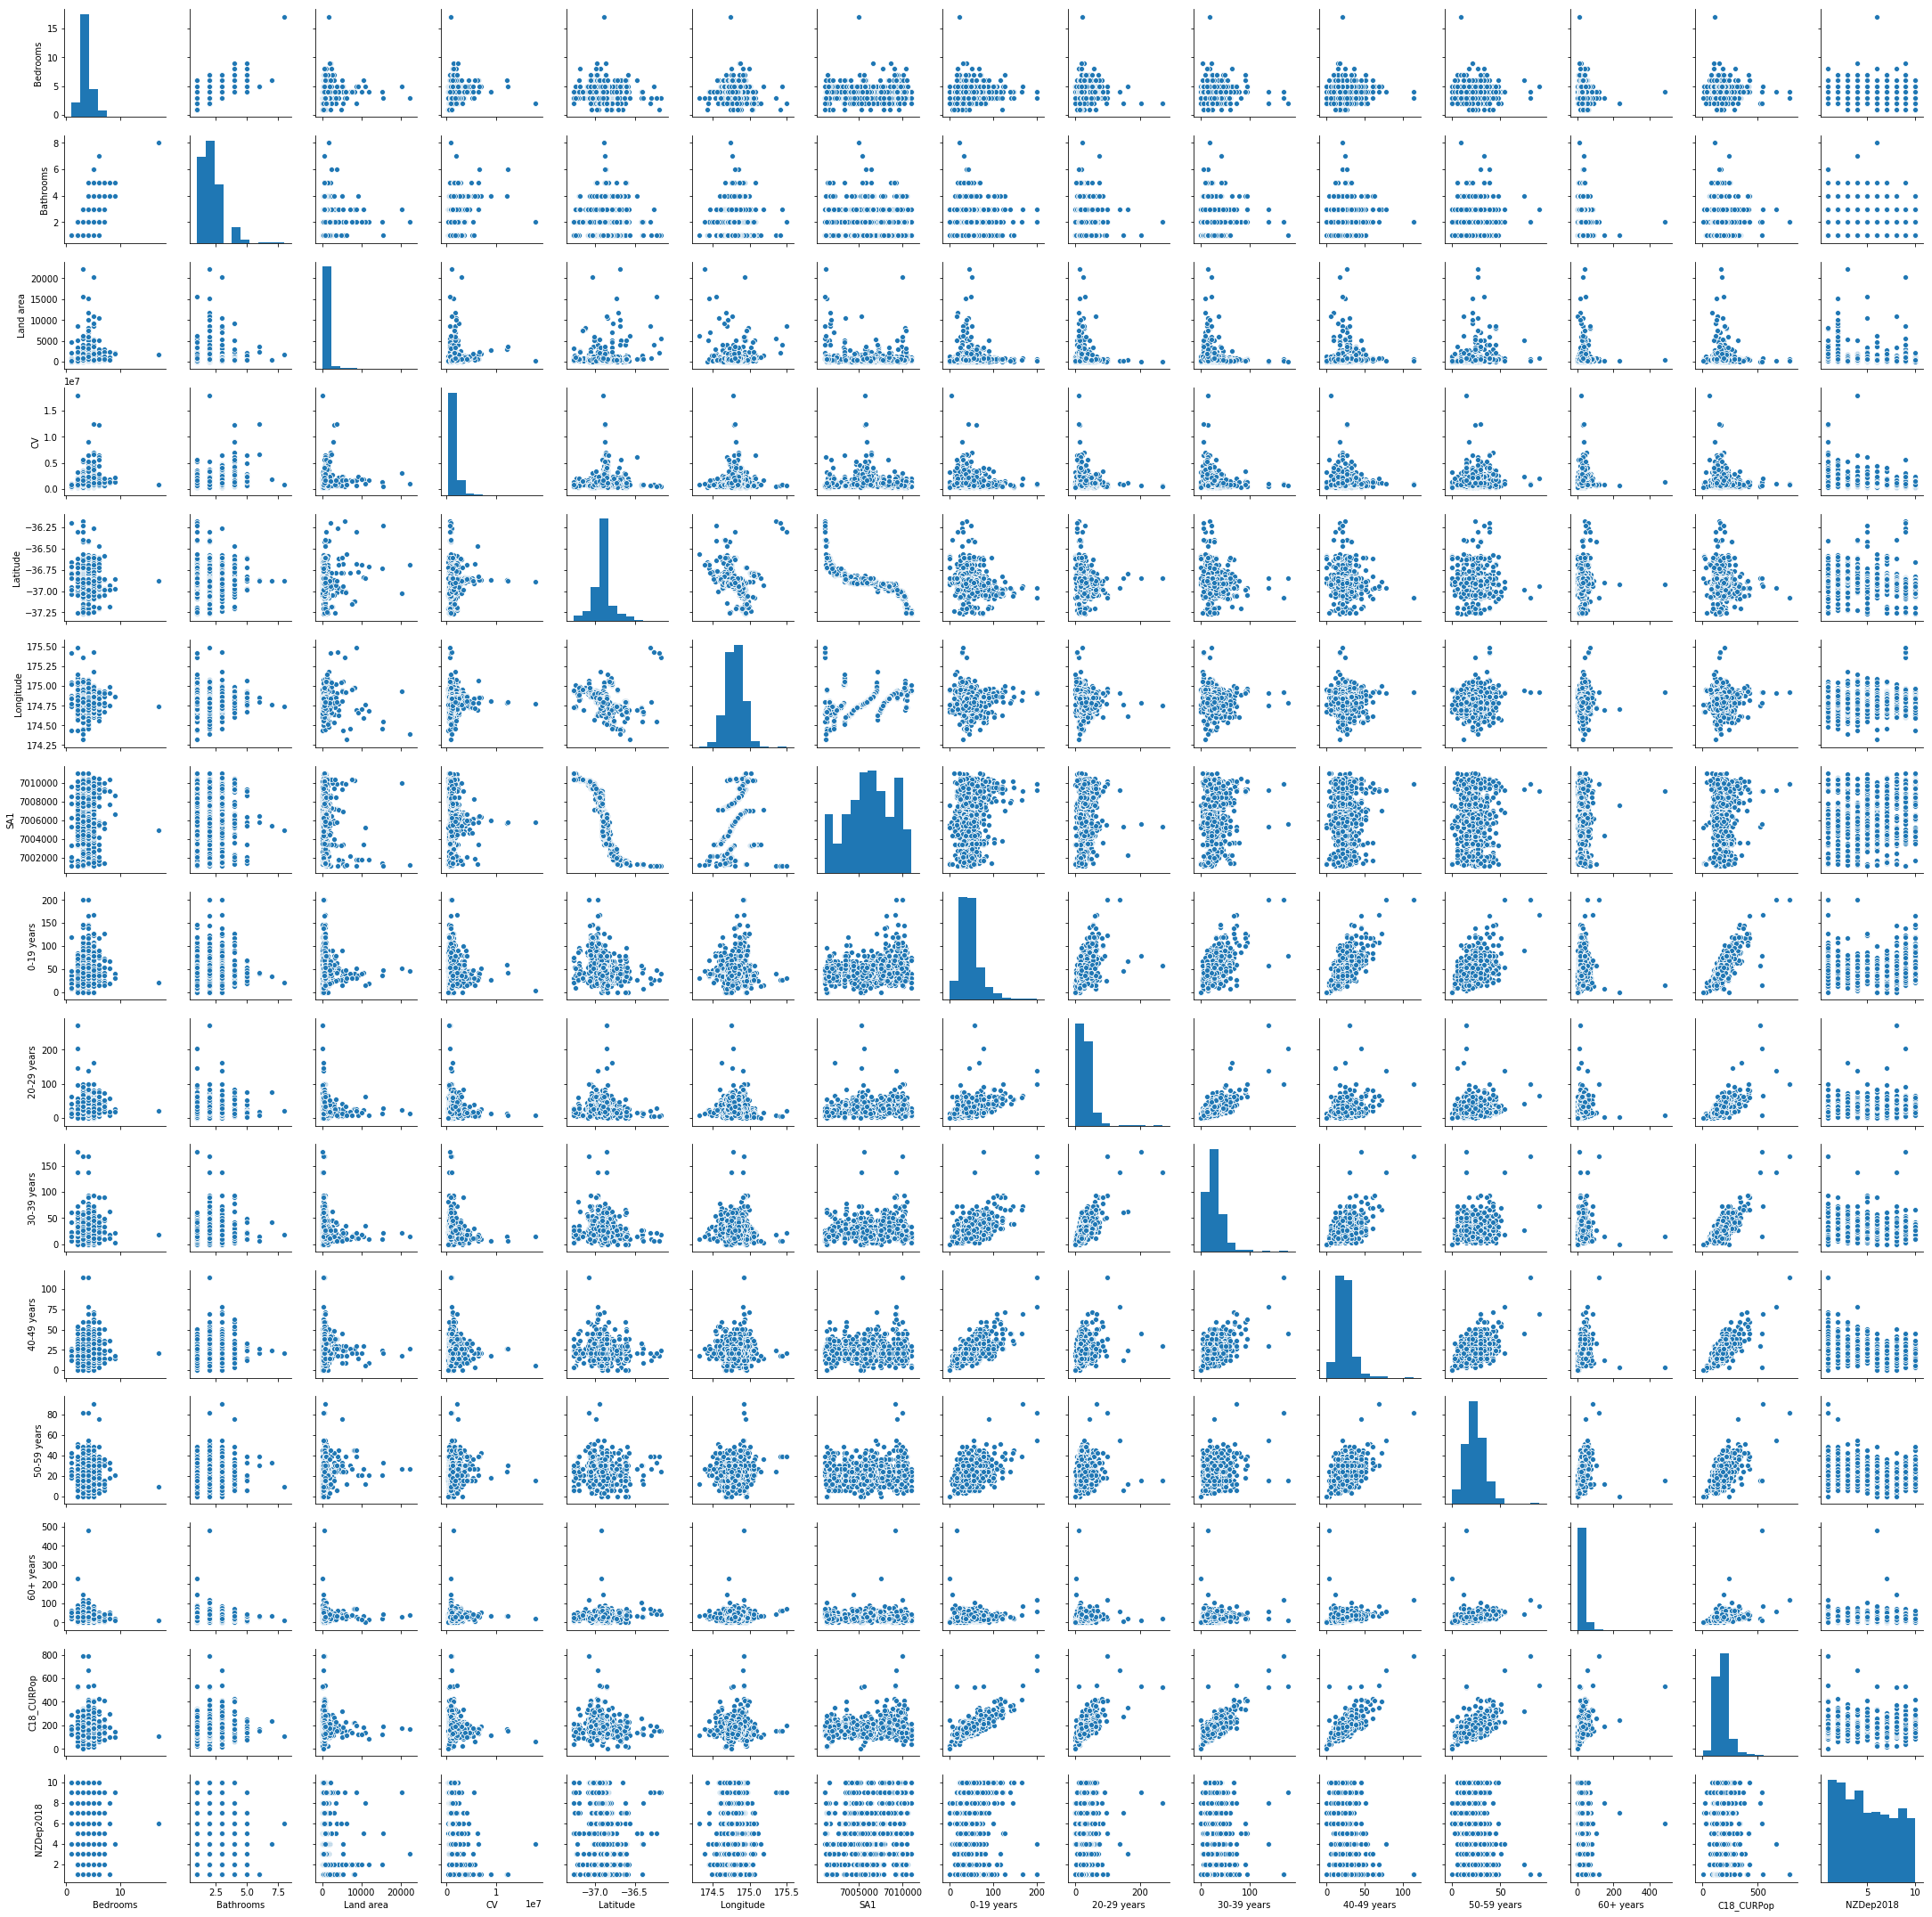

In [319]:
sns.pairplot(joined_df, height = 2.0)

From the pairs plot we notice that there may be an outlier in the bedrooms variables. Some variables are discrete. There doesn't seem to be any obvious relationships. 

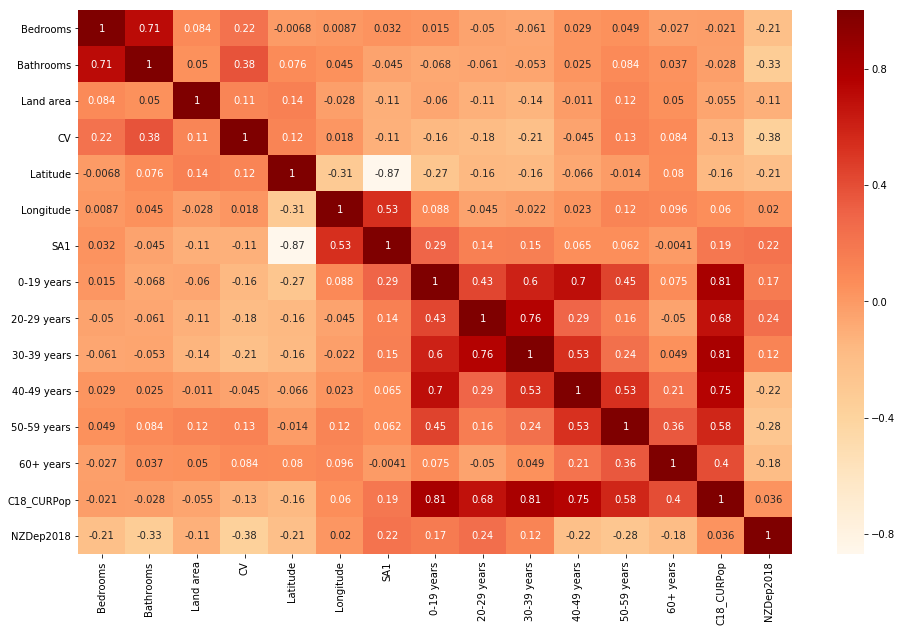

In [320]:
ax, fig = plt.subplots(figsize=(16,10))
correlation_matrix = joined_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="OrRd")
plt.show()

Looking at the CV row, there is not any significant correlations. Looking at the age group factors there is correlation between these factors, such as between 0-19 years and 40-49 years, this makes sense as they would be part of families. 

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


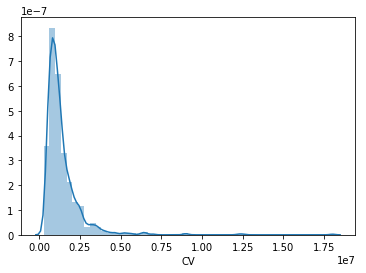

In [321]:
sns.distplot(joined_df['CV'])

Upon closer inspection of the capital value we notice that it is right skewed. Again, suggesting a log transformation is required. 

## 2.3. Extra data cleaning

Remove the outlier for the bedrooms variables

In [323]:
room_outlier = joined_df.index[joined_df['Bedrooms']==joined_df['Bedrooms'].max()][0]

In [324]:
joined_df = joined_df.drop([room_outlier]) 

In [325]:
joined_df.describe()

,Bedrooms,Bathrooms,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,C18_CURPop,NZDep2018
count,1050.000000,1050.000000,1050.000000,1.050000e+03,1050.000000,1050.000000,1.050000e+03,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,3.764762,2.067619,856.285714,1.388118e+06,-36.893724,174.799383,7.006320e+06,47.574286,28.971429,27.051429,24.128571,22.628571,29.377143,179.980000,5.062857
std,1.096357,0.975486,1588.749029,1.183344e+06,0.130162,0.119581,2.592167e+03,24.690355,21.046028,17.981805,10.947559,10.206782,21.808829,71.061263,2.914716
min,1.000000,1.000000,40.000000,2.700000e+05,-37.265021,174.317078,7.001130e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000
25%,3.000000,1.000000,320.000000,7.800000e+05,-36.950644,174.720427,7.004415e+06,33.000000,15.000000,15.000000,18.000000,15.000000,18.000000,138.000000,2.000000
50%,4.000000,2.000000,570.500000,1.080000e+06,-36.893250,174.798612,7.006329e+06,45.000000,24.000000,24.000000,24.000000,21.000000,27.000000,174.000000,5.000000
75%,4.000000,3.000000,825.000000,1.600000e+06,-36.855781,174.880945,7.008384e+06,57.000000,36.000000,33.000000,30.000000,27.000000,36.000000,210.000000,8.000000
max,9.000000,7.000000,22240.000000,1.800000e+07,-36.177655,175.492424,7.011028e+06,201.000000,270.000000,177.000000,114.000000,90.000000,483.000000,789.000000,10.000000


In [326]:
joined_df.head()

,Bedrooms,Bathrooms,Address,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,Suburbs,C18_CURPop,NZDep2018
0,5,3.0,"106 Lawrence Crescent Hill Park, Auckland",714.0,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,Manurewa,174,6.0
1,5,3.0,"8 Corsica Way Karaka, Auckland",564.0,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,Karaka,129,1.0
2,6,4.0,"243 Harbourside Drive Karaka, Auckland",626.0,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,Karaka,129,1.0
3,2,1.0,"2/30 Hardington Street Onehunga, Auckland",65.0,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,Onehunga,120,2.0
4,3,1.0,"59 Israel Avenue Clover Park, Auckland",601.0,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,Clover Park,231,9.0


## 2.4. Modelling 

In [328]:
from sklearn.model_selection import train_test_split

Drop variables that are not numeric

In [329]:
model_df = joined_df.drop(['Address','Suburbs'],axis=1) 

In [330]:
model_df.head()

,Bedrooms,Bathrooms,Land area,CV,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,C18_CURPop,NZDep2018
0,5,3.0,714.0,960000,-37.012920,174.904069,7009770,48,27,24,21,24,21,174,6.0
1,5,3.0,564.0,1250000,-37.063672,174.922912,7009991,42,18,12,21,15,30,129,1.0
2,6,4.0,626.0,1250000,-37.063580,174.924044,7009991,42,18,12,21,15,30,129,1.0
3,2,1.0,65.0,740000,-36.912996,174.787425,7007871,42,6,21,21,12,15,120,2.0
4,3,1.0,601.0,630000,-36.979037,174.892612,7008902,93,27,33,30,21,33,231,9.0


Create the model matrix (x) and response variable (y)

In [331]:
x = model_df.drop(['CV'],axis=1) 

In [332]:
x.head()

,Bedrooms,Bathrooms,Land area,Latitude,Longitude,SA1,0-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60+ years,C18_CURPop,NZDep2018
0,5,3.0,714.0,-37.012920,174.904069,7009770,48,27,24,21,24,21,174,6.0
1,5,3.0,564.0,-37.063672,174.922912,7009991,42,18,12,21,15,30,129,1.0
2,6,4.0,626.0,-37.063580,174.924044,7009991,42,18,12,21,15,30,129,1.0
3,2,1.0,65.0,-36.912996,174.787425,7007871,42,6,21,21,12,15,120,2.0
4,3,1.0,601.0,-36.979037,174.892612,7008902,93,27,33,30,21,33,231,9.0


In [335]:
y = model_df['CV']

Create the train and test datasets for linear regression

In [336]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.25,random_state=1)

In [337]:
from sklearn.linear_model import LinearRegression


In [338]:
model = LinearRegression()

In [339]:
model.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [340]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [341]:
model.coef_

array([-9.24900774e+04,  4.52379335e+05,  4.98279516e+01, -9.54371954e+04,
        1.18917964e+05, -2.41761425e+01,  1.46021816e+04,  1.62194394e+04,
        1.19905572e+03,  2.96027501e+03,  2.32407690e+04,  1.34166052e+04,
       -1.32893585e+04, -1.06503249e+05])

In [342]:
predicted = model.predict(test_x)

Text(0, 0.5, 'predicted_CV')

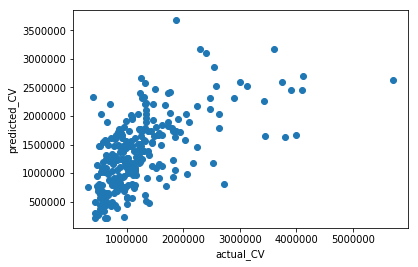

In [343]:
plt.scatter(test_y,predicted)
plt.xlabel('actual_CV')
plt.ylabel('predicted_CV')

In [344]:
model.score(test_x,test_y)

0.27805893870473297

The first model fitted is a simple linear regression. The resulting R^2 value was 27.8%. To improve the model, log transformations were used. 

In [345]:
log_y = np.log(y)

In [346]:
train_x, test_x, train_y, test_y = train_test_split(x,log_y,test_size=0.25,random_state=1)

In [347]:
log_y_model = LinearRegression()

In [348]:
log_y_model.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [349]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [361]:
log_y_model.coef_

array([ 4.57366277e-02,  1.48132049e-01,  2.26222618e-05,  2.93794834e-02,
       -9.58765294e-03, -1.38372420e-05,  1.11110704e-03,  4.11827656e-03,
       -2.67708592e-03,  2.45229959e-03,  8.10319281e-03,  3.31407162e-03,
       -2.70245068e-03, -7.05692788e-02])

In [350]:
log_y_model.score(test_x,test_y)

0.4217693034562491

In [351]:
predicted = log_y_model.predict(test_x)

Text(0, 0.5, 'predicted_CV')

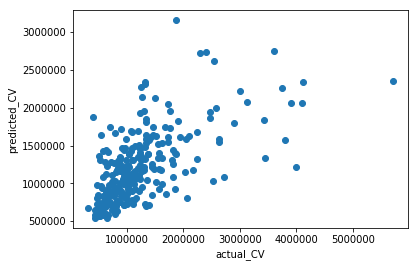

In [352]:
plt.scatter(np.exp(test_y),np.exp(predicted))
plt.xlabel('actual_CV')
plt.ylabel('predicted_CV')

The second model fitted is a simple linear regression, with the response variable log transformed. The resulting R^2 value was 42.2%. To improve this model, the design matrix could also have been logged, however it may not make sense to log some of these variables so this was not attempted. 

Instead of using simple linear regression, a random forest was used to improve the results. 

In [356]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
regressor.fit(train_x, train_y)
pred_y = regressor.predict(test_x)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [357]:
regressor.score(test_x,test_y)

0.5333180780790467

In [358]:
predicted = regressor.predict(test_x)

Text(0, 0.5, 'predicted_CV')

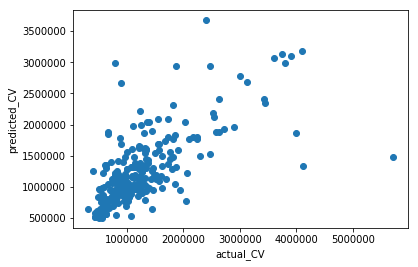

In [359]:
plt.scatter(np.exp(test_y),np.exp(predicted))
plt.xlabel('actual_CV')
plt.ylabel('predicted_CV')

The random forest improved the prediction score to 53.3%. Other methods such as boosting could have been used. 

## 2.5. Conclusion

* The best model achieve was a random forest model with a logged response variable. The prediction score was 53.3%. 
* Improvements to the model:
  * Further analysis into the individual varaibles would have improved the model. Such as taking log transformations or performing other types of transformations 
  * Using other regression methods such as regular trees, boosting or neural networks. 
  * Incorporate the non-numeric values into the model using methods such as encoding. 
  * Since the dataset is not too large, cross-validation could be used to help improve the accuracy of the train and test.  
